In [1]:
import numpy as np
import json
import glob
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
from collections import defaultdict
import tqdm 
from Bio.PDB import PDBParser
import warnings
import pickle
import dfs_code
warnings.filterwarnings('ignore')

In [2]:
path = "/mnt/ssd/datasets/enzyme/"
node_limit = np.inf
cutoff = 8 # 8 also works

In [3]:
glob.glob(path+"*")

['/mnt/ssd/datasets/enzyme/metadata',
 '/mnt/ssd/datasets/enzyme/pdb_files',
 '/mnt/ssd/datasets/enzyme/parsed.json',
 '/mnt/ssd/datasets/enzyme/parsed.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed_n200_dleq4.5.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed_n200_dleq10.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed_leq5.000000.pkl',
 '/mnt/ssd/datasets/enzyme/acid2int.pkl']

In [4]:
with open(path+"metadata/function_labels.json", "r") as f:
    labels = json.load(f)

In [5]:
with open(path+"metadata/base_split.json", "r") as f:
    split = json.load(f)

In [6]:
with open(path+"parsed.pkl", "rb") as f:
    features = pickle.load(f)

In [7]:
max_dist = 0
max_nodes = 0
nodes = []
selected_keys = []
for prot, feats in tqdm.tqdm(features.items()):
    curr_max = np.max(feats['A'])
    n_nodes = len(feats['A'])
    if n_nodes > max_nodes:
        max_nodes = n_nodes
    if curr_max > max_dist:
        max_dist = curr_max
    if n_nodes <= node_limit:
        selected_keys += [prot] 
    nodes += [n_nodes]

100%|███████████████████████████████████████████████████████████████████████| 37428/37428 [00:01<00:00, 22289.67it/s]


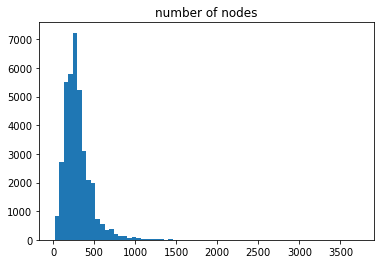

In [8]:
plt.hist(nodes, bins='rice')
plt.title('number of nodes')
plt.show()

In [9]:
n_edges = []
for prot in tqdm.tqdm(selected_keys):
    ds = features[prot]["A"].flatten()
    n_edges += [((ds != 0)*(ds < cutoff)).sum()]

100%|████████████████████████████████████████████████████████████████████████| 37428/37428 [00:08<00:00, 4383.46it/s]


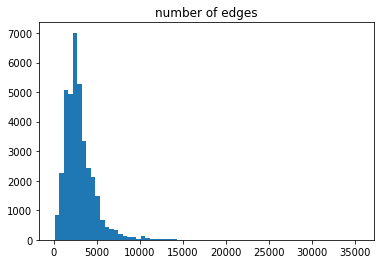

In [10]:
plt.hist(n_edges, bins="rice")
plt.title('number of edges')
plt.show()

In [11]:
bins2 = np.linspace(0, cutoff, 500)
counts2 = np.zeros(len(bins2)-1)

In [12]:
n_edges = []
for prot in tqdm.tqdm(selected_keys):
    ds = features[prot]["A"].flatten()
    counts2 += np.histogram(ds[(ds != 0)*(ds < cutoff)], bins=bins2)[0]

100%|████████████████████████████████████████████████████████████████████████| 37428/37428 [00:13<00:00, 2785.63it/s]


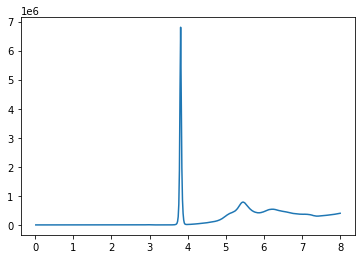

In [13]:
plt.plot(bins2[1:], counts2)

In [14]:
acids = set()
for prot in tqdm.tqdm(selected_keys):
    acids |= set(features[prot]["acid"].tolist())

100%|███████████████████████████████████████████████████████████████████████| 37428/37428 [00:00<00:00, 47815.49it/s]


In [15]:
acids2int = {acid:idx for idx, acid in enumerate(list(acids))}

In [16]:
def d2edge_type(d):
    if d<4:
        return 0
    elif d<5:
        return 1
    elif d<6:
        return 2
    elif d<7:
        return 3
    elif d<8:
        return 4
    elif d<9:
        return 5
    elif d<10:
        return 6
    else:
        return 7

graphs = defaultdict(dict)
exceptions = []
for prot in tqdm.tqdm(selected_keys[3070:3072]):
    D = features[prot]['A']
    plt.matshow(-D)
    plt.show()
    A = (D != 0) * (D < cutoff)
    print(A.sum())
    print(A.shape)
    edge_index = np.asarray(np.where(A))
    print("computed edge index")
    edge_index_set = set((e[0], e[1]) for e in edge_index.T)
    print("computed edge index set")
    node_types = np.asarray([acids2int[acid] for acid in features[prot]['acid']])
    print("computed node types")
    glue_edges = []
    for i in range(len(A)-1):
        if (i, i+1) not in edge_index_set:
            glue_edges += [[i, i+1]]
        if (i+1, i) not in edge_index_set:
            glue_edges += [[i+1, i]]
    print("computed glue edges")
    if len(glue_edges) > 0:
        glue_edges = np.asarray(glue_edges).T
        edge_index = np.concatenate((edge_index, glue_edges), axis=1)
    print("combined edges")
    edge_types = [d2edge_type(D[e[0], e[1]]) for e in edge_index.T]
    print("computed edge types")
    edge_types = np.asarray(edge_types)
    print("converted edge types to array")
    print(len(D))
    print(len(edge_types))
    print(glue_edges)
    min_dfs_code, min_dfs_index = dfs_code.min_dfs_code_from_edgeindex(edge_index, 
                                                                       node_types.tolist(), 
                                                                       edge_types.tolist())
    graphs[prot]['edge_index'] = edge_index
    graphs[prot]['edge_types'] = edge_types
    graphs[prot]['node_types'] = node_types
    graphs[prot]['min_dfs_code'] = min_dfs_code
    graphs[prot]['min_dfs_index'] = min_dfs_index
    graphs[prot]['pos'] = features[prot]['pos']
    del features[prot]

In [ ]:
graphs = defaultdict(dict)
exceptions = []
for prot in tqdm.tqdm(selected_keys):
    D = features[prot]['A'].copy()
    D -= np.eye(len(D))
    A = (D != -1) * (D < cutoff)
    edge_index = np.asarray(np.where(A))
    edge_index_set = set((e[0], e[1]) for e in edge_index.T)
    node_types = np.asarray([acids2int[acid] for acid in features[prot]['acid']])
    glue_edges = []
    for i in range(len(A)-1):
        if (i, i+1) not in edge_index_set:
            glue_edges += [[i, i+1]]
        if (i+1, i) not in edge_index_set:
            glue_edges += [[i+1, i]]
    if len(glue_edges) > 0:
        glue_edges = np.asarray(glue_edges).T
        edge_index = np.concatenate((edge_index, glue_edges), axis=1)
    edge_types = np.asarray([d2edge_type(D[e[0], e[1]]) for e in edge_index.T])
    min_dfs_code, min_dfs_index = dfs_code.min_dfs_code_from_edgeindex(edge_index, 
                                                                       node_types.tolist(), 
                                                                       edge_types.tolist())
    graphs[prot]['edge_index'] = edge_index
    graphs[prot]['edge_types'] = edge_types
    graphs[prot]['node_types'] = node_types
    graphs[prot]['min_dfs_code'] = min_dfs_code
    graphs[prot]['min_dfs_index'] = min_dfs_index
    graphs[prot]['pos'] = features[prot]['pos']
    del features[prot]


 19%|█████████████▉                                                             | 6955/37428 [38:42<39:16, 12.93it/s]

In [ ]:
trainset = set(split['train'])
validset = set(split['valid'])
testset = set(split['test'])

In [ ]:
for key in graphs.keys():
    graphs[key]['label'] = labels[key]
    if key in trainset:
        graphs[key]['split'] = "train"
    elif key in validset:
        graphs[key]['split'] = "valid"
    elif key in testset:
        graphs[key]['split'] = "test"
    else:
        raise ValueError("unexpected")

In [ ]:
with open(path+"min_dfs_transformer_preprocessed_leq%f.pkl"%cutoff, "wb") as f:
    pickle.dump(graphs, f)

In [ ]:
with open(path+"acid2int.pkl", "wb") as f:
    pickle.dump(acids2int, f)